This notebook builds a neural network using a transformer from a pretrained HuBERT model, attaching a linear layer and activation layer. At first, the transformer is frozen, and only the linear layer is trained. The performance is very similar to the performance of a logistic regression model using HuBERT features (as it should be). Then the HuBERT transformer is unfrozen, and the model is trained for additional epochs at a low learning rate.



In [71]:
from pathlib import Path

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, log_loss
from sklearn.model_selection import (
    cross_val_predict,
    cross_val_score,
    cross_validate,
    StratifiedKFold,
    RepeatedStratifiedKFold,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
import torchaudio

datadir = Path("../data/wav")

In [2]:
# Pretrained HuBERT model
bundle = torchaudio.pipelines.HUBERT_BASE
pretrained_hubert_model = bundle.get_model()

# List of data files
data_files = pd.read_csv("../data/directory_w_train_test.csv")
data_files_p5 = data_files.loc[data_files.Participant == "P05"]
label_counts = data_files_p5.Label.value_counts()
training_files = data_files_p5.loc[
    data_files_p5.Label.isin(label_counts[label_counts >= 30].index)
    & (data_files_p5.is_test == 0)
]

In [3]:
waveform_list = []
for filename in tqdm(training_files.Filename):
    waveform, sample_rate = torchaudio.load(datadir / filename)
    waveform = torchaudio.functional.resample(
        waveform, sample_rate, bundle.sample_rate
    )
    waveform_list.append(waveform)

  0%|          | 0/777 [00:00<?, ?it/s]

In [4]:
labels = training_files.Label.unique()
y = torch.zeros(len(training_files), dtype=torch.int)
for idx, label in enumerate(labels):
    y[(training_files.Label == label).values] = idx
print(y.shape)

torch.Size([777])


In [106]:
class HubertFeaturesWithLayer(nn.Module):
    def __init__(self, pretrained_hubert_model, output_size):
        super().__init__()
        self.feature_extractor = pretrained_hubert_model.feature_extractor
        self.feature_projection = (
            pretrained_hubert_model.encoder.feature_projection
        )
        self.pos_conv_embed = (
            pretrained_hubert_model.encoder.transformer.pos_conv_embed
        )
        self.layer_norm = pretrained_hubert_model.encoder.transformer.layer_norm
        self.transformer_layer = (
            pretrained_hubert_model.encoder.transformer.layers[0]
        )
        self.linear = nn.Linear(768, output_size)
        self.softmax = nn.Softmax(1)
        self.freeze()

    def forward(self, waveform, features=False):
        if features:
            x = waveform
        else:
            x = self.hubert_features(waveform)
        pred = self.softmax(self.linear(x))
        return pred

    def hubert_features(self, waveform):
        if waveform.ndim == 3 and waveform.shape[0] == 1:
            waveform = waveform.squeeze(0)
        x = self.feature_extractor(waveform, None)[0]
        x = self.feature_projection(x)
        x = x + self.pos_conv_embed(x)
        x = self.layer_norm(x)
        x = self.transformer_layer(x)[0].mean((0, 1)).unsqueeze(0)
        return x

    def freeze(self):
        for param in self.transformer_layer.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.transformer_layer.parameters():
            param.requires_grad = True
        # Not sure whether to unfreeze just one layer, or all
        # So far neither works very well :/
        # for param in self.parameters():
        #     param.requires_grad = True

In [95]:
model = HubertFeaturesWithLayer(pretrained_hubert_model, len(labels))

# dl = torch.utils.data.DataLoader(
#     list(zip(waveform_list, y.long())), shuffle=True
# )
ds = list(zip(waveform_list, y.long()))
val_size = len(ds) // 5
train_ds, val_ds = torch.utils.data.random_split(
    ds,
    [len(ds) - val_size, val_size],
    generator=torch.Generator().manual_seed(12345),
)
train_dl = torch.utils.data.DataLoader(train_ds, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, shuffle=False)

In [96]:
with torch.no_grad():
    train_dl_features = torch.utils.data.DataLoader(
        [
            (model.hubert_features(waveform).squeeze(0), label)
            for waveform, label in tqdm(train_dl)
        ],
        shuffle=True,
        batch_size=32,
    )
    val_dl_features = torch.utils.data.DataLoader(
        [
            (model.hubert_features(waveform).squeeze(0), label)
            for waveform, label in tqdm(val_dl)
        ],
        batch_size=32,
    )

  0%|          | 0/622 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

In [8]:
# Compute the standard deviation of each hubert feature. This
# is used for regularization.
with torch.no_grad():
    feature_list = []
    for waveform in tqdm(waveform_list):
        feature_list.append(model.hubert_features(waveform))
    X = torch.stack(feature_list)
    std_by_feature = X.std(0)

  0%|          | 0/777 [00:00<?, ?it/s]

In [9]:
train_dl_features_list = list(train_dl_features)
X_tr = torch.cat([wf for wf, _ in train_dl_features_list])
y_tr = torch.cat([label for _, label in train_dl_features_list]).squeeze(1)
val_dl_features_list = list(val_dl_features)
X_v = torch.cat([wf for wf, _ in val_dl_features_list])
y_v = torch.cat([label for _, label in val_dl_features_list]).squeeze(1)

X_tr.shape, y_tr.shape, X_v.shape, y_v.shape

(torch.Size([622, 768]),
 torch.Size([622]),
 torch.Size([155, 768]),
 torch.Size([155]))

In [10]:
# Logistic regression model. This will be a baseline for
# the neural network using first hubert layer
est = make_pipeline(
    StandardScaler(), LogisticRegression(C=0.0133, max_iter=10**8)
)
est.fit(X_tr, y_tr)
pred_log = est.predict_proba(X_v)
print("Logistic val logloss:", nn.NLLLoss()(torch.tensor(pred_log).log(), y_v))
print("Logistic val acc:", (pred_log.argmax(1) == y_v.numpy()).mean())

Logistic val logloss: tensor(0.8877, dtype=torch.float64)
Logistic val acc: 0.7096774193548387


In [109]:
model = HubertFeaturesWithLayer(pretrained_hubert_model, len(labels))
opt = torch.optim.Adam(model.parameters(), lr=5e-4)

val_accs = []
for epoch in tqdm(range(1, 125)):
    loss = 0
    for count, (wf, label) in enumerate(train_dl_features):
        pred = model(wf, features=True)
        loss = nn.NLLLoss()(pred.log(), label.squeeze(1))
        # loss += (
        #     (model.linear.weight**2 * std_by_feature**2).sum()
        #     / (2 * C * len(train_dl))
        # )
        opt.zero_grad()
        loss.backward()
        opt.step()
    if epoch % 10 == 0 or True:
        with torch.no_grad():
            val_acc = (
                sum(
                    (model(wf, features=True).argmax(1) == label.squeeze(1))
                    .float()
                    .sum()
                    for wf, label in val_dl_features
                )
                / len(val_dl)
            ).item()
            # print(f"Epoch {epoch}, val acc:", val_acc)
            val_accs.append(val_acc)

  0%|          | 0/124 [00:00<?, ?it/s]

0.7390029430389404 117


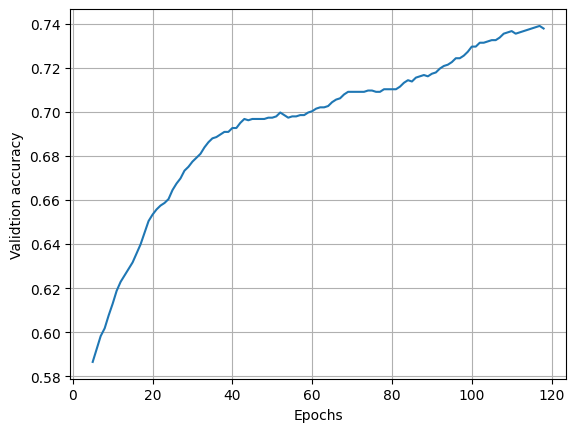

In [110]:
# Performance is very similar to the logistic regression

with torch.no_grad():
    val_pred_0 = torch.cat(
        [model(wf, features=True).argmax(1) for wf, label in val_dl_features]
    )
    val_label = torch.cat([label for wf, label in val_dl_features]).squeeze(1)
assert (y_v == val_label).all()

smoothed_val_acc = sum(pd.Series(val_accs).shift(n) for n in range(-5, 6)) / 11
print(smoothed_val_acc.max(), smoothed_val_acc.argmax())
plt.plot(smoothed_val_acc)
plt.xlabel("Epochs")
plt.ylabel("Validtion accuracy")
plt.grid()

In [112]:
# Unfreeze a layer of the pretrained model (this layer is a
# transformer). Then run a few more training epochs, with a
# lower learning rate.
model.unfreeze()
opt = torch.optim.Adam(model.parameters(), lr=3e-5)

In [113]:
# Perform additional training, computing validation accuracy after
# every batch. The accuracies jump around a fair bit, so I also
# estimate a p-value for the hypothesis "the model has better accuracy
# after the additional training". I tried this both with and without
# regularization, neither way seemed to be systematically better than
# leaving the transformer frozen.
C = 50
batch_size = 32
val_accs = []
for epoch in range(1, 4):
    loss = 0
    for count, (wf, label) in enumerate(train_dl):
        pred = model(wf)
        loss = loss + nn.NLLLoss()(pred.log(), label)
        if count % batch_size == batch_size - 1 or count == len(train_dl) - 1:
            loss = loss / batch_size + (
                model.linear.weight**2 * std_by_feature**2
            ).sum() / (2 * C * len(train_dl))
            opt.zero_grad()
            loss.backward()
            opt.step()
            loss = 0
            with torch.no_grad():
                preds = []
                labs = []
                for wf, label in val_dl:
                    preds.append(model(wf).argmax(1).item())
                    labs.append(label[0])
                preds = torch.tensor(preds)
                labs = torch.tensor(labs)
                assert (labs == val_label).all()
                print(
                    f"Epoch {epoch}.{(count+1)//batch_size}, "
                    f"val acc: {(labs == preds).float().mean().item():.3f}",
                )
                diff = (preds == val_label).float() - (
                    val_pred_0 == val_label
                ).float()
                p1 = (diff == 1).float().mean()  # new model better
                p2 = (diff == -1).float().mean()  # old model better
                num_new_model_better = (diff == 1).int().sum().item()
                num_old_model_better = (diff == -1).int().sum().item()
                print(
                    f"New better: {num_new_model_better},  old better: {num_old_model_better}"
                )
                std = np.sqrt(
                    (p1 * (1 - p1) + p2 * (1 - p2)) / len(diff)
                ).item()
                z = (p1 - p2).item() / std
                p = norm.sf(z)
                print(f"p-value (lower is better): {p:.3f}\n")

Epoch 1.1, val acc: 0.658
New better: 6,  old better: 17
p-value (lower is better): 0.992

Epoch 1.2, val acc: 0.658
New better: 8,  old better: 19
p-value (lower is better): 0.987

Epoch 1.3, val acc: 0.632
New better: 5,  old better: 20
p-value (lower is better): 0.999

Epoch 1.4, val acc: 0.652
New better: 4,  old better: 16
p-value (lower is better): 0.998

Epoch 1.5, val acc: 0.600
New better: 6,  old better: 26
p-value (lower is better): 1.000

Epoch 1.6, val acc: 0.626
New better: 8,  old better: 24
p-value (lower is better): 0.999

Epoch 1.7, val acc: 0.658
New better: 5,  old better: 16
p-value (lower is better): 0.994

Epoch 1.8, val acc: 0.716
New better: 8,  old better: 10
p-value (lower is better): 0.686

Epoch 1.9, val acc: 0.703
New better: 8,  old better: 12
p-value (lower is better): 0.823

Epoch 1.10, val acc: 0.697
New better: 7,  old better: 12
p-value (lower is better): 0.882

Epoch 1.11, val acc: 0.703
New better: 7,  old better: 11
p-value (lower is better): 0.83